In [26]:
import datetime
import os
import random
from copy import copy
from uuid import UUID
from pprint import pprint
import itertools
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from dotenv import load_dotenv

from pot.network.dumper import Dumper
from pot.network.node import SelfNodeInfo
from pot.network.storage import (
    BlocksStorage,
    NodeStorage,
    TransactionStorage,
    NodeTrustStorage,
    ValidatorStorage,
    TransactionVerifiedStorage,
)
from pot.network.manager import NodeTrust

BASE_PATH = "/home/pp/programs/magisterka/monitor/simulation_25_02_04_1738701107/simulation_2/"
storage_path = os.path.realpath(
    os.path.join(BASE_PATH, "storage")
)
result_path = os.path.realpath(
    os.path.join(BASE_PATH, "result")
)

firsts_records = None

load_dotenv()

True

In [27]:
def get_info_from_nodes(path: str) -> dict:
    storage = NodeStorage(path)
    nodes = storage.load()
    trust = NodeTrust.__new__(NodeTrust)
    trust._storage = NodeTrustStorage(path)
    # trust._storage.load()
    # print(f"Trust from {path}: {trust._storage.load()}")
    # old_value = os.getenv('STORAGE_DIR')
    # os.putenv('STORAGE_DIR', path)
    # self_node = SelfNodeInfo()
    # os.putenv('STORAGE_DIR', old_value)
    return {
        "len": len(nodes),
        # "trust": trust.get_node_trust(self_node.get_node())
        "trust": trust._storage.load(),
    }

def get_self_node_info(path: str) -> UUID:
    old_value = os.getenv("STORAGE_DIR")
    os.environ["STORAGE_DIR"] = path
    self_node = SelfNodeInfo(True)
    os.environ["STORAGE_DIR"] = old_value
    return self_node.identifier

In [28]:
df_trust = pd.DataFrame(columns=["time", "sourceNode", "node", "trust"])
df_trust.set_index(["time", "sourceNode", "node"], inplace=True)
# df_trust.sort_index()

first_time = None
dfs = {}

nodes_mapping = {}

In [29]:
for node in os.listdir(storage_path):
    # list all nodes in dir
    if node == ".gitignore":
        continue
    print(f"Processing node {node}")

    trust_data = []

    dirs = [
        int(time_dir)
        for time_dir in os.listdir(os.path.join(storage_path, node, "dump"))
    ]
    dirs.sort()
    print(f"Found {len(dirs)} dirs in node {node}")

    record_i = 0
    for time in dirs:
        time_int = int(time)
        time = float(time) / Dumper.SECOND_PART
        # list all time in dir
        if not first_time:
            first_time = time

        if firsts_records is not None:
            if firsts_records < record_i:
                break

        storage_dir = os.path.join(storage_path, node, "dump", str(time_int))
        # print(f"Processing dir {storage_dir}")

        if node not in nodes_mapping.keys():
            self_node_id = get_self_node_info(storage_dir)
            nodes_mapping[node] = self_node_id.hex
            print(self_node_id.hex)

        try:
            nodes_info = get_info_from_nodes(storage_dir)
        except Exception as e:
            print(f"Exception {e} while loading from node: {node} from time {time}")
            raise e

        actual_time = time - first_time
        for node_id, trust in nodes_info["trust"].items():
            trust_data.append(
                {
                    "time": actual_time,
                    "sourceNode": node,
                    "node": node_id.hex,
                    "trust": trust,
                }
            )
        record_i += 1

    df_trust_node = pd.DataFrame(
        trust_data, columns=["time", "sourceNode", "node", "trust"]
    )
    df_trust_node.set_index(["time", "sourceNode", "node"], inplace=True)

    df_trust = pd.concat([df_trust, df_trust_node])


Processing node 1c8a38306acf
Found 5004 dirs in node 1c8a38306acf
c52d771fa0dd468a8b6aeeedfc3d6ea1
Processing node d46875aa2c3d
Found 5204 dirs in node d46875aa2c3d
ef9175328f8245b4bc38fc6c38c033fd
Processing node b6e9d66583a2
Found 4904 dirs in node b6e9d66583a2
ff620193780a4d029099aa637392ef30
Processing node 73ca033ec3fa
Found 4952 dirs in node 73ca033ec3fa
a1faf701950a4f698f45ca77bee8a5a3
Processing node 7ae7f40ccd44
Found 5101 dirs in node 7ae7f40ccd44
bc488dc0d621421c88d79a97a0a33ade
Processing node 7a42ea3a1aa3
Found 4848 dirs in node 7a42ea3a1aa3
239d3ae384204b3bb8652f0043c65af6
Processing node 936ba6d476ae
Found 5052 dirs in node 936ba6d476ae
a457b16e01694c3b9ba150fe97cefd56


In [30]:
df_trust.head()

trust
time                sourceNode   node                                  
0.0                 1c8a38306acf bc488dc0d621421c88d79a97a0a33ade  5000
                                 a457b16e01694c3b9ba150fe97cefd56  5000
0.10000014305114746 1c8a38306acf bc488dc0d621421c88d79a97a0a33ade  5000
                                 a457b16e01694c3b9ba150fe97cefd56  5000
0.20000004768371582 1c8a38306acf bc488dc0d621421c88d79a97a0a33ade  5000

In [31]:
nodes_ids = df_trust.reset_index()["node"].unique()
print("Nodes map")
pprint(nodes_mapping)
print("Nodes")
pprint(nodes_ids)

Nodes map
{'1c8a38306acf': 'c52d771fa0dd468a8b6aeeedfc3d6ea1',
 '73ca033ec3fa': 'a1faf701950a4f698f45ca77bee8a5a3',
 '7a42ea3a1aa3': '239d3ae384204b3bb8652f0043c65af6',
 '7ae7f40ccd44': 'bc488dc0d621421c88d79a97a0a33ade',
 '936ba6d476ae': 'a457b16e01694c3b9ba150fe97cefd56',
 'b6e9d66583a2': 'ff620193780a4d029099aa637392ef30',
 'd46875aa2c3d': 'ef9175328f8245b4bc38fc6c38c033fd'}
Nodes
array(['bc488dc0d621421c88d79a97a0a33ade',
       'a457b16e01694c3b9ba150fe97cefd56',
       'ef9175328f8245b4bc38fc6c38c033fd',
       'c52d771fa0dd468a8b6aeeedfc3d6ea1',
       'ff620193780a4d029099aa637392ef30',
       'a1faf701950a4f698f45ca77bee8a5a3',
       '239d3ae384204b3bb8652f0043c65af6'], dtype=object)


In [46]:
node_id = nodes_ids[random.randint(0, len(nodes_ids) - 1)]
node_name = list(nodes_mapping.keys())[list(nodes_mapping.values()).index(node_id)]

print(f"Processing trust for node {node_id} => {node_name}")
    # Plot trust for node - all
pivot = (
    df_trust.xs(node_id, level=2)
    .reset_index()
    .pivot(index="time", columns="sourceNode", values="trust")
)
pivot

Processing trust for node c52d771fa0dd468a8b6aeeedfc3d6ea1 => 1c8a38306acf


sourceNode,1c8a38306acf,73ca033ec3fa,7a42ea3a1aa3,7ae7f40ccd44,936ba6d476ae,b6e9d66583a2,d46875aa2c3d
time,,,,,,,
-8.8,NaN,NaN,NaN,NaN,NaN,NaN,5000
-8.7,NaN,NaN,NaN,NaN,NaN,NaN,5000
-8.6,NaN,NaN,NaN,NaN,NaN,NaN,5000
-8.5,NaN,NaN,NaN,NaN,NaN,NaN,5000
-8.4,NaN,NaN,NaN,NaN,NaN,NaN,5000
...,...,...,...,...,...,...,...
515.3,5314,5315,5315,5315,5315,5315,5315
515.4,5314,NaN,NaN,NaN,5315,5315,5315
515.5,5314,5315,5315,5315,5315,5315,5315


In [41]:
pivot.iloc[0].unique()

array([nan, 5000], dtype=object)

In [47]:
# Calculate the mean and std of changes time
change_times = []

changes_to_end = []
# Iterate over the rows of the pivot DataFrame
for i in range(1, len(pivot)):
    row = pivot.iloc[i]
    
    # Check if there are no NaN values in the current row
    if row.isnull().any():
        continue
    # Check if the trust values have changed compared to the previous row
    if row.equals(pivot.iloc[i - 1]):
        continue

    pprint(change_to_end)

    for change_to_end in changes_to_end:
        trust = change_to_end["trust"]
        nodes_to_wait = change_to_end["nodes"]
        for node in nodes_to_wait:
            if row[node] >= trust:
                change_to_end["nodes"].remove(node)

        # Check if there are any nodes that have not yet reached the trust level
        if len(change_to_end["nodes"]) == 0:
            change_times.append(float(i - change_to_end["time"]) / 10.0)#Dumper.SECOND_PART)
            changes_to_end.remove(change_to_end)

    unique_trust_values = row.unique()
    if len(unique_trust_values) == 1:
        change_times.append(1.0 / 10.0)#Dumper.SECOND_PART)
    else:
        for trust_value in unique_trust_values:
            changes_to_end.append(
                {
                    "time": i,
                    "trust": trust_value,
                    "nodes": list(row[row < trust_value].index),
                }
            )

pprint(change_times)

# Calculate mean and std of change times
mean_change_time = np.mean(change_times)
std_change_time = np.std(change_times)

print(f"Mean change time: {mean_change_time}")
print(f"Standard deviation of change times: {std_change_time}")

{'nodes': [], 'time': 5293, 'trust': 5088}
{'nodes': [], 'time': 5293, 'trust': 5088}
{'nodes': [], 'time': 489, 'trust': 5000}
{'nodes': [], 'time': 490, 'trust': 5000}
{'nodes': [], 'time': 491, 'trust': 5002}
{'nodes': [], 'time': 492, 'trust': 5003}
{'nodes': [], 'time': 492, 'trust': 5004}
{'nodes': [], 'time': 495, 'trust': 5004}
{'nodes': [], 'time': 496, 'trust': 5004}
{'nodes': [], 'time': 497, 'trust': 5005}
{'nodes': [], 'time': 498, 'trust': 5005}
{'nodes': [], 'time': 508, 'trust': 5005}
{'nodes': [], 'time': 514, 'trust': 5005}
{'nodes': [], 'time': 536, 'trust': 5005}
{'nodes': ['1c8a38306acf', '7a42ea3a1aa3', '7ae7f40ccd44', 'd46875aa2c3d'],
 'time': 539,
 'trust': 5007}
{'nodes': [], 'time': 540, 'trust': 5006}
{'nodes': ['1c8a38306acf', '7ae7f40ccd44', 'b6e9d66583a2', 'd46875aa2c3d'],
 'time': 541,
 'trust': 5008}
{'nodes': [], 'time': 542, 'trust': 5007}
{'nodes': [], 'time': 543, 'trust': 5007}
{'nodes': [], 'time': 544, 'trust': 5007}
{'nodes': [], 'time': 551, 'tr

<Axes: xlabel='time'>

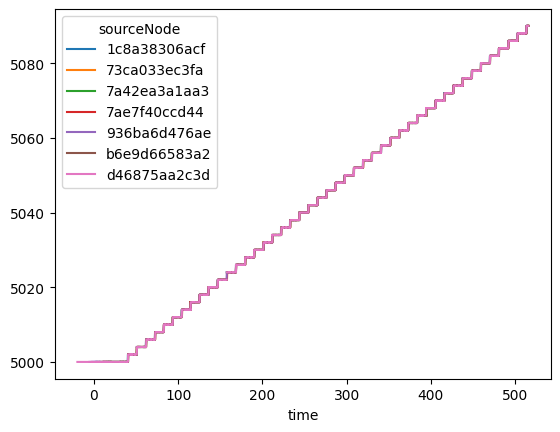

In [45]:
pivot.plot()

In [23]:
for node_id in nodes_ids:
    if node_id not in list(nodes_mapping.values()):
        print(f"{node_id} not found in nodes_mapping")
        continue
    node_name = list(nodes_mapping.keys())[list(nodes_mapping.values()).index(node_id)]

    print(f"Processing trust for node {node_id} => {node_name}")
    # Plot trust for node - all
    pivot = (
        df_trust.xs(node_id, level=2)
        .reset_index()
        .pivot(index="time", columns="sourceNode", values="trust")
    )
    pivot.head()

Processing trust for node d63ac78eb7bd4251b0634a88e425acda => 19c1cd671ca4
Processing trust for node ddd25f83f65641d28d0e1579ce042347 => 6f3be43eda95
Processing trust for node ba8f5f5df2624810b117fd88a3729d54 => b60c606d5c01
Processing trust for node e39a79c6dbec4529a629cd2c8eb3df93 => e2e7ab84a2ad
Processing trust for node c183a48a39244d99829520da34fbe8a2 => c98291eca91d
Processing trust for node 04d80e8acfff400da6621ad5489c54b6 => 2d1ddcc9f646
Processing trust for node c4fe1917632a4e8ba35c233f7db695db => bd425cb2c176
